In [4]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing


In [55]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import np_utils

In [22]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
import keras
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  3.8.0


In [77]:
def read_data(file_path):
    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    data = []
    skipped_lines_count = 0
    processed_lines_count = 0
    with open(file_path, 'r') as f:
        for line in f:
            processed_lines_count += 1
            # Split the line by comma
            values = line.strip().split(',')
            # Check if the line has the expected number of fields
            if len(values) == len(column_names):
                # Remove the semicolon from the z-axis value
                values[5] = values[5].replace(';', '')
                data.append(values)
            else:
                skipped_lines_count += 1
                # Optional: Print info about skipped lines to diagnose
                # print(f"Skipped line {processed_lines_count}: Expected {len(column_names)} fields, found {len(values)}. Content: {line.strip()}")


    print(f"Total lines read from file: {processed_lines_count}")
    print(f"Lines skipped due to incorrect field count: {skipped_lines_count}")
    print(f"Lines processed and added to data list: {len(data)}")


    df = pd.DataFrame(data, columns=column_names)

    # Convert appropriate columns to numeric types
    df['user-id'] = pd.to_numeric(df['user-id'], errors='coerce')
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['x-axis'] = pd.to_numeric(df['x-axis'], errors='coerce')
    df['y-axis'] = pd.to_numeric(df['y-axis'], errors='coerce')
    df['z-axis'] = pd.to_numeric(df['z-axis'], errors='coerce')

    print("\nNaN counts after numeric conversion (before dropna):")
    print(df[['user-id', 'timestamp', 'x-axis', 'y-axis', 'z-axis']].isnull().sum())

    print(f"\nNumber of rows after numeric conversion (before dropna): {len(df)}")

    # Drop rows where 'z-axis' is NaN
    df.dropna(subset=['z-axis'], inplace=True)
    print(f"Number of rows after dropping rows with NaN in z-axis: {len(df)}")


    return df

def convert_to_float(x):
    # This function might not be needed anymore with pd.to_numeric
    try:
        return np.float(x)
    except:
        return np.nan

def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

Total lines read from file: 1098210
Lines skipped due to incorrect field count: 11744
Lines processed and added to data list: 1086466

NaN counts after numeric conversion (before dropna):
user-id      0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64

Number of rows after numeric conversion (before dropna): 1086466
Number of rows after dropping rows with NaN in z-axis: 1086465


In [78]:
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [79]:
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1086465



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


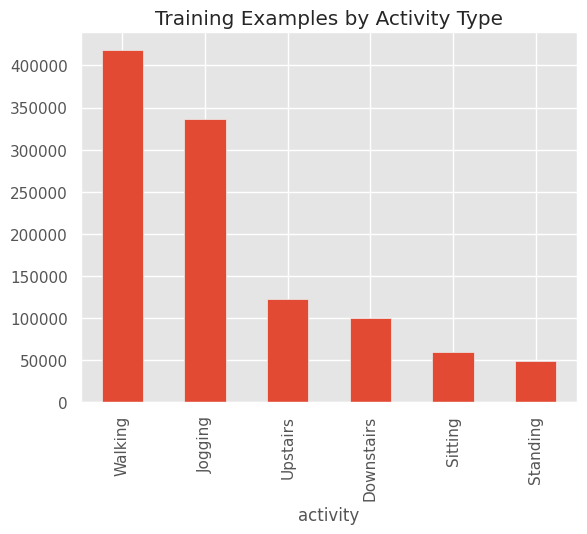

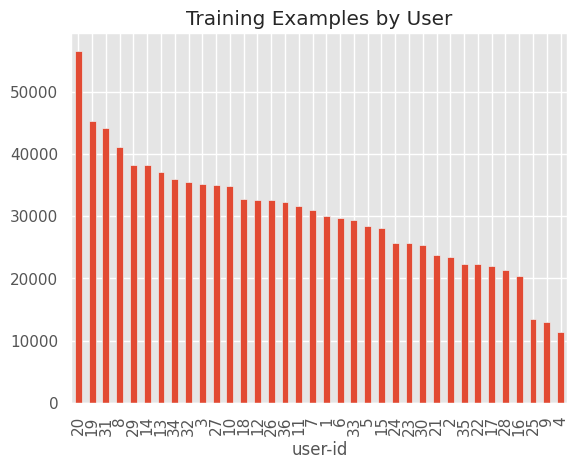

In [80]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

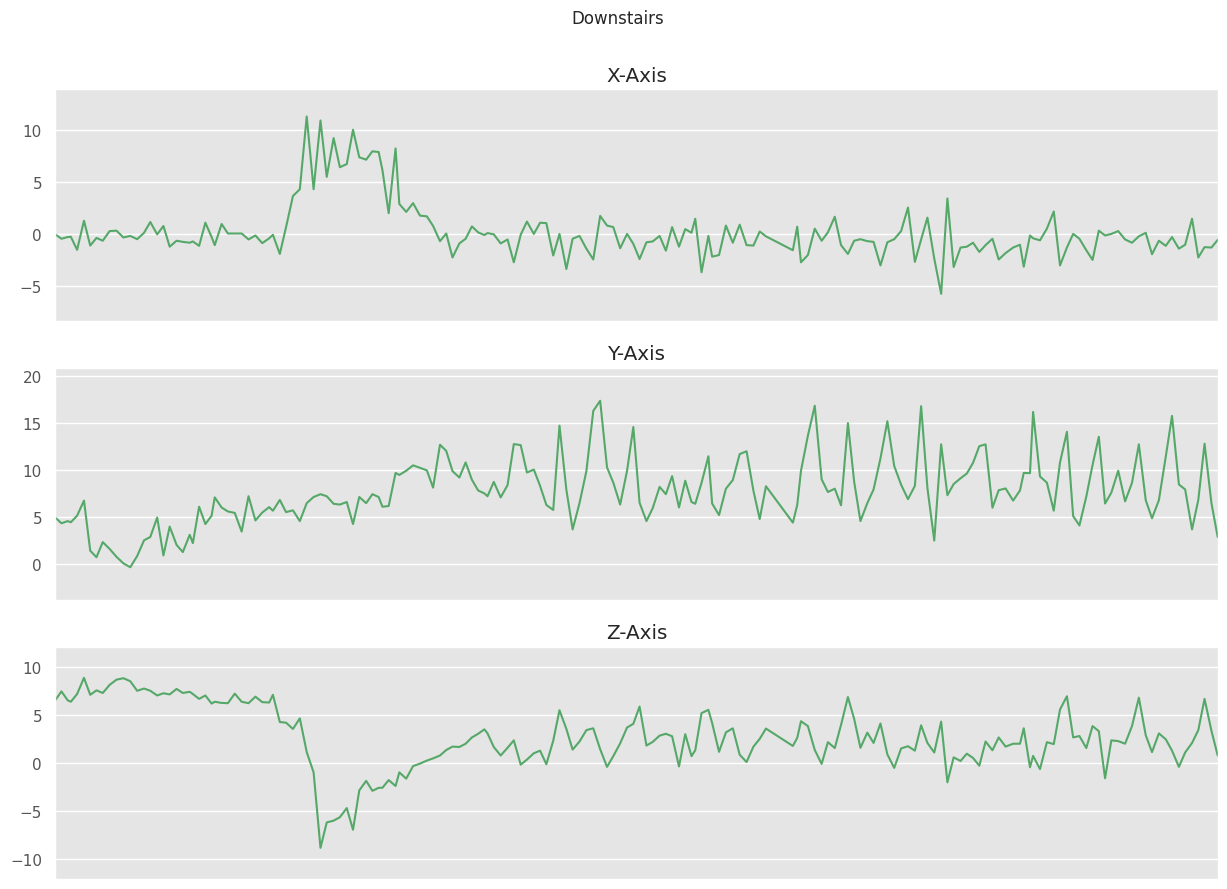

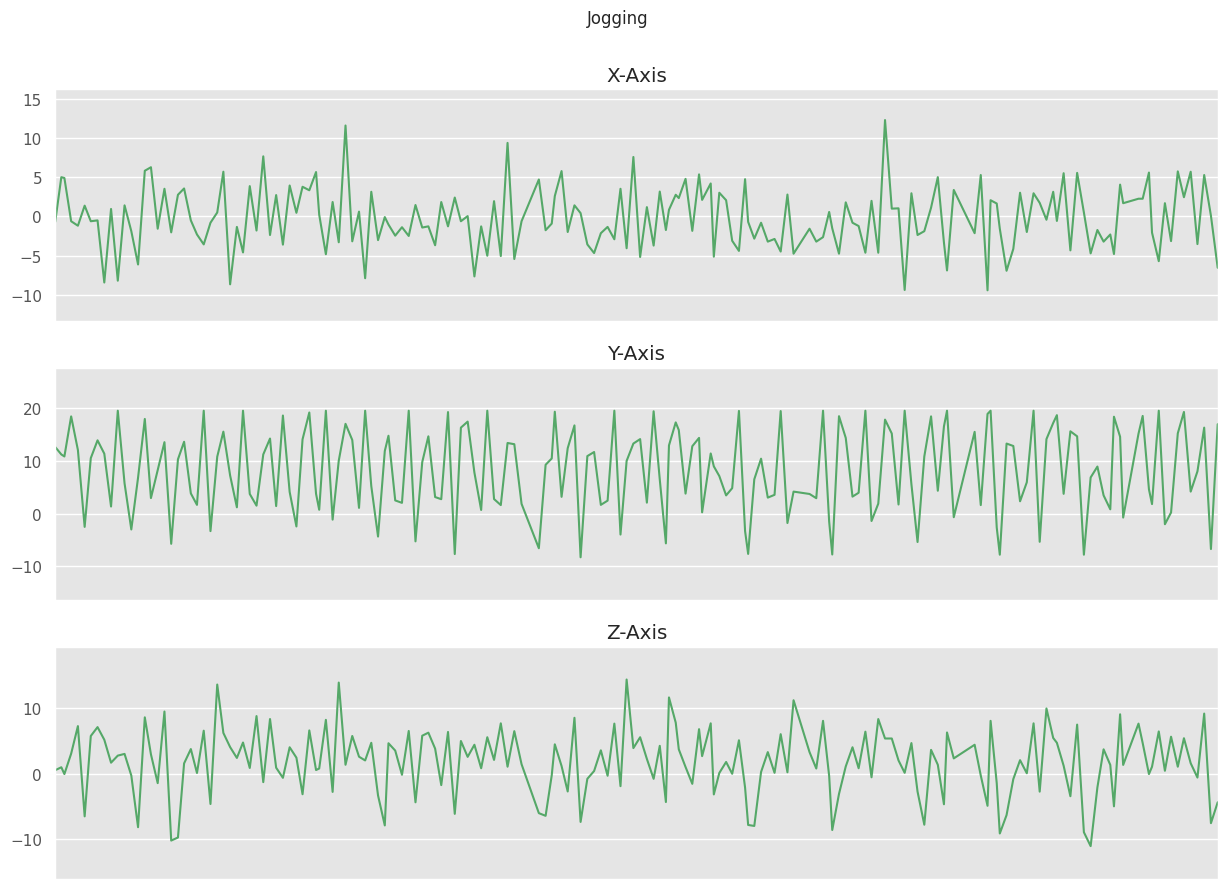

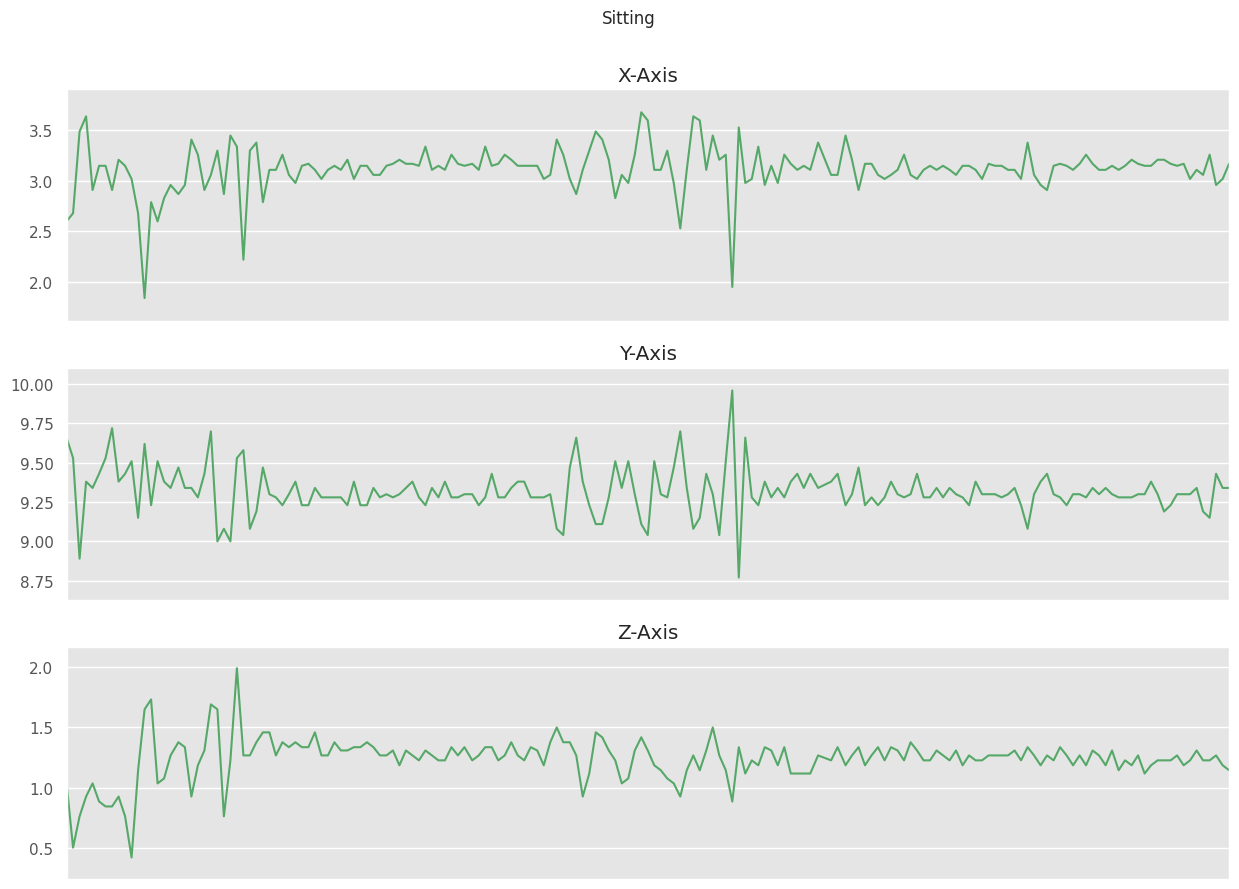

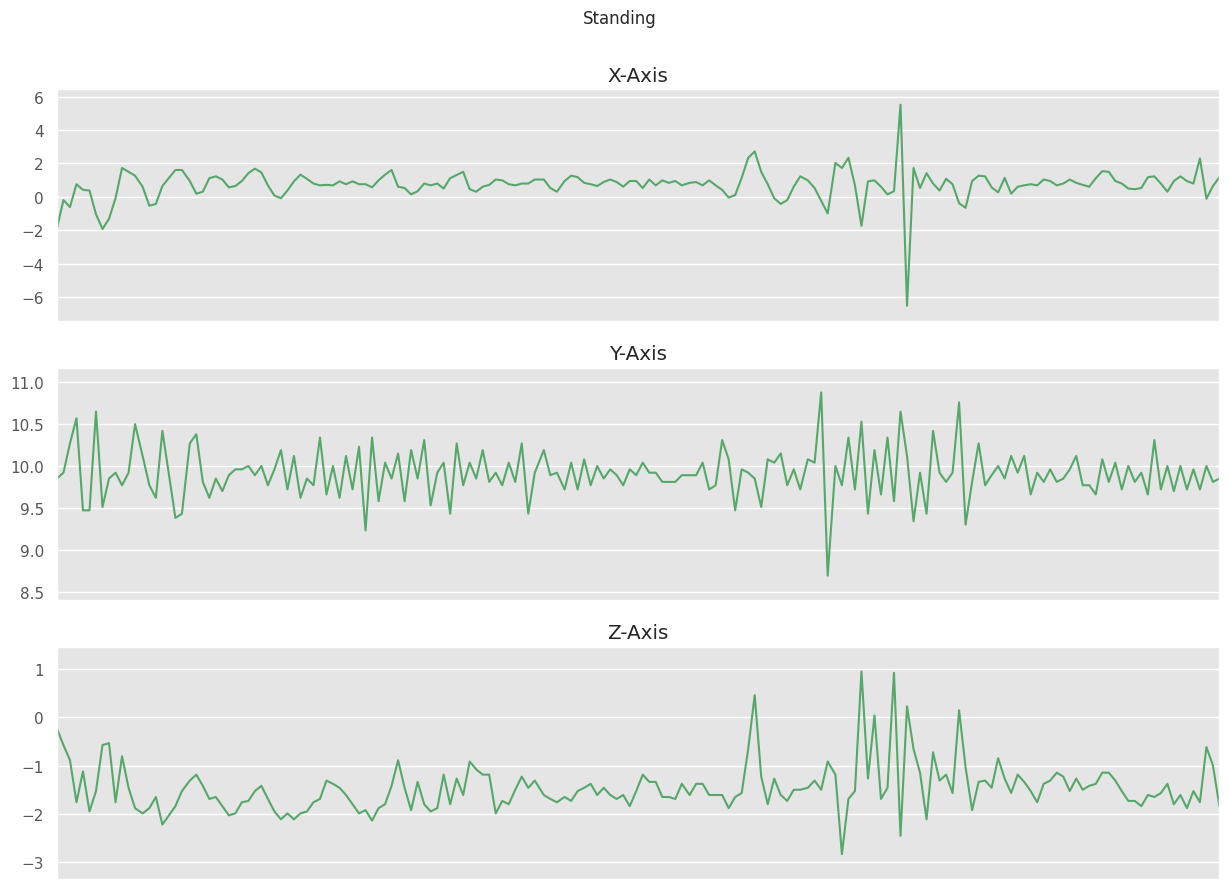

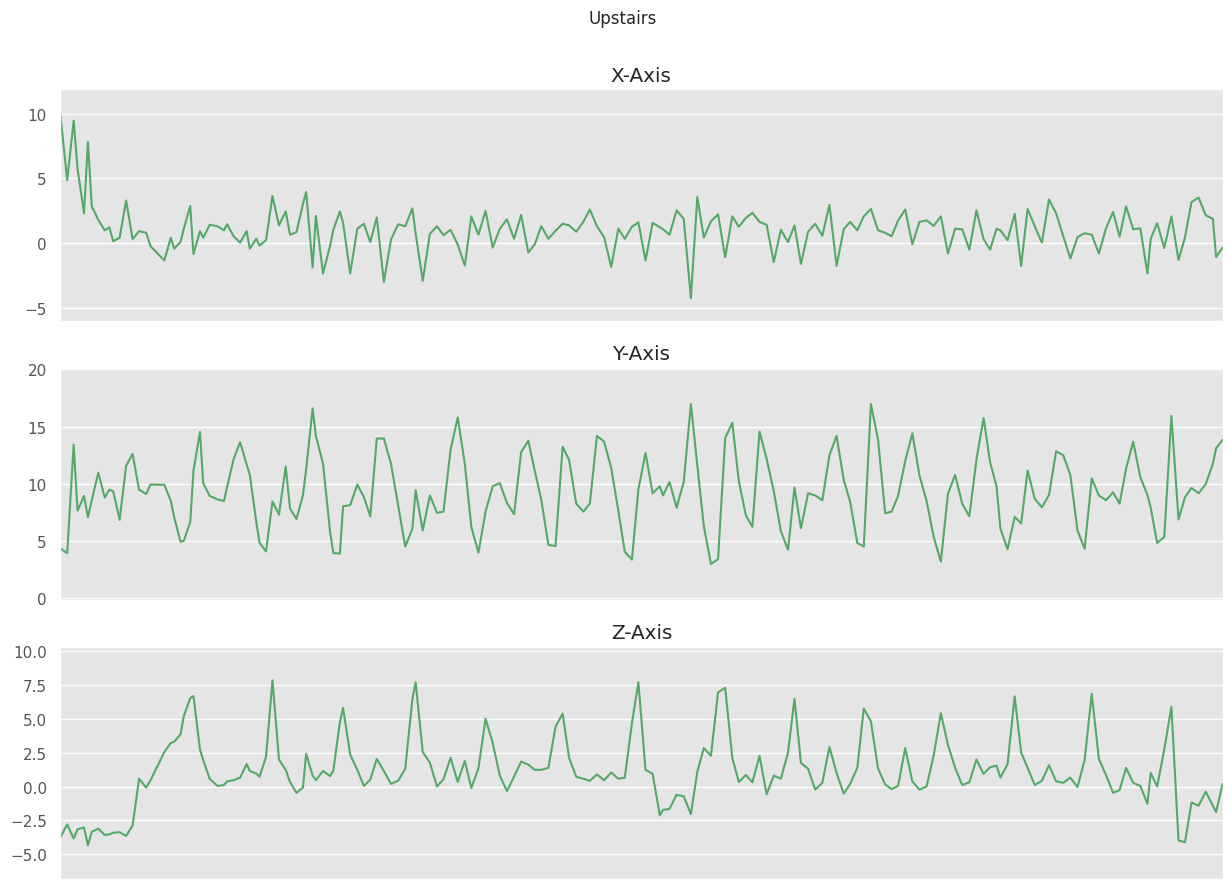

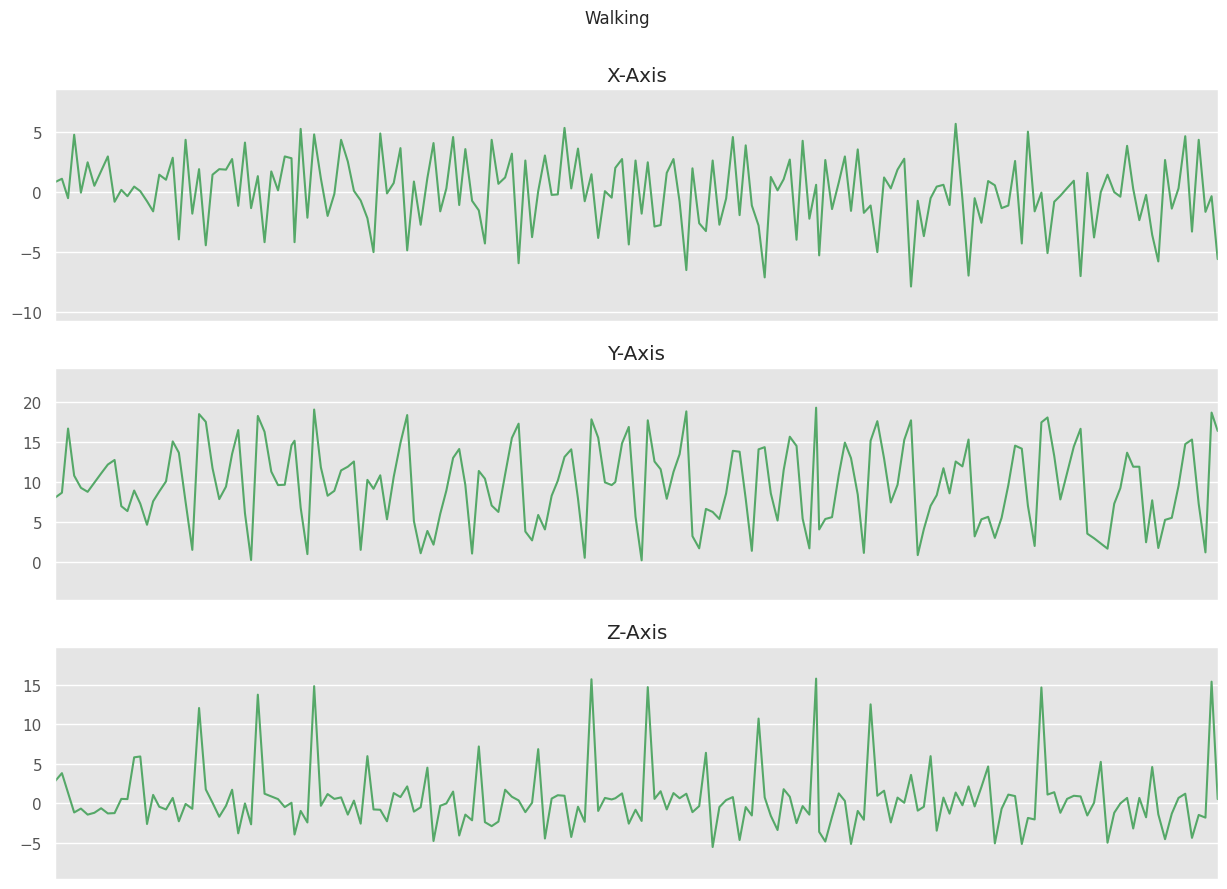

In [34]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [81]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [82]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [83]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps], keepdims=True).mode[0]

        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [84]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20575, 80, 3)
20575 training samples
y_train shape:  (20575,)


In [85]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [86]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20575, 240)
input_shape: 240


In [87]:
from tensorflow.keras.utils import to_categorical

In [88]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
y_train_hot = to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20575, 6)


In [99]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 80, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 80, 100)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 80, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 80, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,606 (267.99 KB)

 Trainable params: 68,606 (267.99 KB)

 Non-trainable params: 0 (0.00 B)

None


In [101]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1 , mode='max')
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 300
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7824 - loss: 0.6274

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.7825 - loss: 0.6268 - val_accuracy: 0.8265 - val_loss: 0.6482
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.8080 - loss: 0.5212 - val_accuracy: 0.8219 - val_loss: 0.6617
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.8150 - loss: 0.5004 - val_accuracy: 0.7648 - val_loss: 0.6831
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.8283 - loss: 0.4697 - val_accuracy: 0.7521 - val_loss: 0.6955
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.8350 - loss: 0.4446 - val_accuracy: 0.7708 - val_loss: 0.6784
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.8440 - loss: 0.4222 - val_accuracy: 0.8245 - val_loss: 0.6684
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.8518 - loss: 0.4110 - val_accuracy: 0.7903 - val_loss: 0.6878
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.8621 - loss: 0.3830 - val_accuracy: 0.7570 

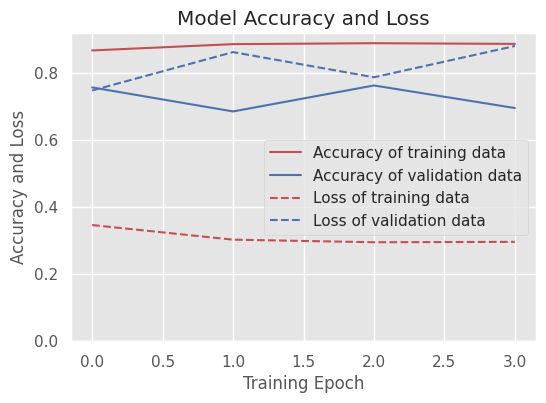

643/643 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
              precision    recall  f1-score   support

         0.0       0.63      0.47      0.54      1866
         1.0       0.99      0.97      0.98      6426
         2.0       0.98      1.00      0.99      1048
         3.0       0.99      0.99      0.99       834
         4.0       0.55      0.75      0.63      2339
         5.0       0.89      0.86      0.88      8062

    accuracy                           0.86     20575
   macro avg       0.84      0.84      0.83     20575
weighted avg       0.87      0.86      0.86     20575



In [95]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [97]:
# Normalize features for training data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7557 - loss: 0.8768

Accuracy on test data: 0.73

Loss on test data: 1.23


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


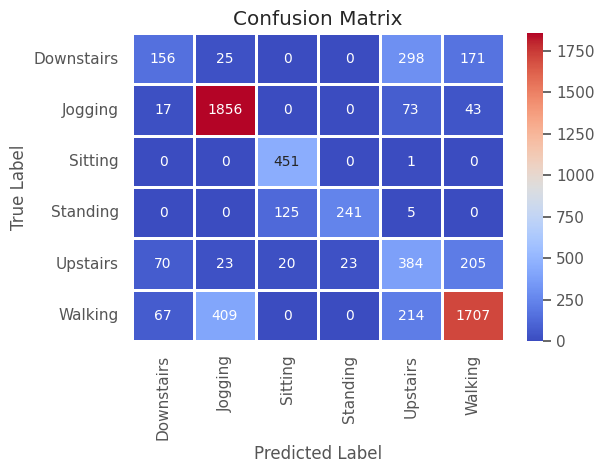

              precision    recall  f1-score   support

           0       0.50      0.24      0.33       650
           1       0.80      0.93      0.86      1989
           2       0.76      1.00      0.86       452
           3       0.91      0.65      0.76       371
           4       0.39      0.53      0.45       725
           5       0.80      0.71      0.75      2397

    accuracy                           0.73      6584
   macro avg       0.70      0.68      0.67      6584
weighted avg       0.73      0.73      0.72      6584



In [98]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))